# Multi-Scenario MORDM

Multi-scenario MORDM is an extension of normal MORDM to better include robustness considerations within the search phase. It starts from the scenario discovery results resulting from MORDM. Next, from the experiments within this box, a set of scenarios is selected. 

There are many ways of selecting the additional scenarios. The original paper which introduced multi-scenario MORMD [Watson and Kaspzryk (2017)](https://doi.org/10.1016/j.envsoft.2016.12.001) did it in a more or less adhoc manner. [Eker and Kwakkel (2018)](https://doi.org/10.1016/j.envsoft.2018.03.029) introduced a more formal selection approach, the code of which can be found on [GitHub](https://github.com/sibeleker/MORDM---Multi-scenario-search). 

For this assignment, make an informed selection of 4 scenarios, using an approach of your choice. Motivate carefully your selection procedure. 


In [1]:
from dps_lake_model import lake_model
import os
from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, SequentialEvaluator, ema_logging,
                           Constant, Scenario, Policy)
from ema_workbench.analysis import prim
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench import Constraint
from ema_workbench.analysis import parcoords
import pandas as pd
from ema_workbench import load_results
import matplotlib.pyplot as plt
import numpy as np

C:\Users\jryap\anaconda3\envs\mbdm\lib\site-packages\ema_workbench\analysis\prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)


In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
lake_m = Model('lakemodel', function=lake_model)

#specify uncertainties
lake_m.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_m.levers = [RealParameter('c1', -2, 2),
                     RealParameter('c2', -2, 2),
                     RealParameter('r1', 0, 2),
                     RealParameter('r2', 0, 2),
                     RealParameter('w1', 0, 1)]

#specify outcomes 
lake_m.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

# lake_model.constantcs = [Constant('alpha', 0.41),
#                          Constant('reps', 150)],

convergence_metrics = [HyperVolume.from_outcomes(lake_m.outcomes),
                       EpsilonProgress()]

# constraints = [Constraint("max pollution", outcome_names="max_P")]

In [ ]:
a = load_results(os.getcwd() + '/results/selected_results.tar.gz')

In [ ]:
experiments, outcomes = a

specify the reference scenario.
there's a value of bqmean std which we get from the results

then pass the reference scenario into the optimizers
searchover='levers' again

In assignment 8 optimized using 1 default scenario for the default uncertainty value.

Assignment 9 - optimize over 4 scenarios or 4 diff scenarios for uncertainties.

Select scenarios
Search for each scenarios, search for each one independently. End up with four dataframes.
COmpile the results and compile them into one dataframe.

Reevaluate under deep certainty. Perform experiments. 

In [ ]:
outcomes_df = pd.DataFrame(outcomes)

In [ ]:
all= pd.concat([experiments, outcomes_df], axis=1)

In [ ]:
scenarios = []

for i in range(len(outcomes_df.columns)):
    if outcomes_df.columns[i] == "max_P":
        scenarios.append(all.sort_values(by=outcomes_df.columns[i], ascending=False).reset_index()["scenario"][0])
    else:
        scenarios.append(all.sort_values(by=outcomes_df.columns[i]).reset_index()["scenario"][0])

In [ ]:
scenarios

In [ ]:
b = []
q = []
delta = []
mean = []
stdev = []

for i in scenarios:
    b.append(experiments[experiments["scenario"]==i]["b"].iloc[0])
    q.append(experiments[experiments["scenario"]==i]["q"].iloc[0])
    mean.append(experiments[experiments["scenario"]==i]["mean"].iloc[0])
    delta.append(experiments[experiments["scenario"]==i]["delta"].iloc[0])
    stdev.append(experiments[experiments["scenario"]==i]["stdev"].iloc[0])

In [ ]:
uncertainties = pd.DataFrame([b,q,mean,delta,stdev], index=["b", "q", "mean", "delta", "stdev"]).T

In [ ]:
reference = []

for i,uncertainty in uncertainties.iterrows():
    reference.append(Scenario(str(i),**uncertainty.to_dict()))

## Search for each scenario

For each of the four selected scenarios, use many-objective optimization to find a pareto approximate set using the same approach as for assignment 8. Remember to check for convergence (and time permitting, seed analysis), and be careful in what epsilon values to use (not to coarse, not too small). 

Store the resulting set of pareto solutions in a smart way for subsequent analysis.

In [ ]:
with MultiprocessingEvaluator(lake_m) as evaluator:
    results0 = evaluator.optimize(searchover='levers', nfe=5000, epsilons=[0.05, 0.05] * len(lake_m.outcomes), 
                                 convergence=convergence_metrics, reference=reference[0])

In [ ]:
with MultiprocessingEvaluator(lake_m) as evaluator:
    results1 = evaluator.optimize(searchover='levers', nfe=5000, epsilons=[0.05, 0.05] * len(lake_m.outcomes), 
                                 convergence=convergence_metrics, reference=reference[1])

In [ ]:
with MultiprocessingEvaluator(lake_m) as evaluator:
    results2 = evaluator.optimize(searchover='levers', nfe=5000, epsilons=[0.05, 0.05] * len(lake_m.outcomes), 
                                 convergence=convergence_metrics, reference=reference[2])

In [ ]:
with MultiprocessingEvaluator(lake_m) as evaluator:
    results3 = evaluator.optimize(searchover='levers', nfe=5000, epsilons=[0.05, 0.05] * len(lake_m.outcomes), 
                                 convergence=convergence_metrics, reference=reference[3])

In [ ]:
results_all = [results0, results1, results2, results3]

for i in range(len(results_all)):
    limits = parcoords.get_limits(results_all[i][0].iloc[:, 5:])
    axes = parcoords.ParallelAxes(limits)
    axes.plot(results_all[i][0].iloc[:, 5:])
    axes.legend()

    # we invert this axis so direction of desirability is the same 
    axes.invert_axis('utility') 
    axes.invert_axis('inertia') 
    axes.invert_axis('reliability') 
    axes.invert_axis('max_P') 
    plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(12,8))
ax[0,0].plot(results0[1].nfe, results0[1].epsilon_progress)
ax[0,0].set_ylabel('$\epsilon$-progress')

ax[0,1].plot(results0[1].nfe, results0[1].hypervolume)
ax[0,1].set_ylabel('hypervolume')

ax[1,0].plot(results1[1].nfe, results1[1].epsilon_progress)
ax[1,0].set_ylabel('$\epsilon$-progress')

ax[1,1].plot(results1[1].nfe, results1[1].hypervolume)
ax[1,1].set_ylabel('hypervolume')

ax[2,0].plot(results2[1].nfe, results2[1].epsilon_progress)
ax[2,0].set_ylabel('$\epsilon$-progress')

ax[2,1].plot(results2[1].nfe, results2[1].hypervolume)
ax[2,1].set_ylabel('hypervolume')

ax[3,0].plot(results3[1].nfe, results3[1].epsilon_progress)
ax[3,0].set_ylabel('$\epsilon$-progress')

ax[3,1].plot(results3[1].nfe, results3[1].hypervolume)
ax[3,1].set_ylabel('hypervolume')

ax[0,0].set_xlabel('number of function evaluations')
ax[0,1].set_xlabel('number of function evaluations')
ax[1,0].set_xlabel('number of function evaluations')
ax[1,1].set_xlabel('number of function evaluations')
ax[2,0].set_xlabel('number of function evaluations')
ax[2,1].set_xlabel('number of function evaluations')
ax[3,0].set_xlabel('number of function evaluations')
ax[3,1].set_xlabel('number of function evaluations')
plt.show()

## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.


In [ ]:
results0[0]["indicator"] = outcomes_df.columns[0]
results1[0]["indicator"] = outcomes_df.columns[1]
results2[0]["indicator"] = outcomes_df.columns[2]
results3[0]["indicator"] = outcomes_df.columns[3]

In [ ]:
results_all = pd.concat([results0[0], results1[0], results2[0], results3[0]])

In [ ]:
policy = results_all.iloc[:,:5]

In [ ]:
policies = []

for i,policy in policy.iterrows():
    policies.append(Policy(str(i),**policy.to_dict()))

In [ ]:
%%time
with MultiprocessingEvaluator(lake_m) as evaluator:
    new_experiments, new_outcomes = evaluator.perform_experiments(scenarios=1000, policies=policies,
                                                                uncertainty_sampling="lhs")

Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.

visualize the results in parallel coordinate plot. 

Are there any promising compromise solutions which balance performance in both the reference scenarios as well as in terms of their robustness?


In [3]:
import seaborn as sns

In [ ]:
optimized_results = pd.concat([new_experiments, pd.DataFrame(new_outcomes)], axis=1)

In [ ]:
lists = optimized_results.policy.unique()

In [ ]:
# optimized_results["colour"] = None

# for i, color in zip(range(len(lists)), sns.color_palette(n_colors=len(lists))):
#     if optimized_results[optimized_results['policy']==lists[i]]:
#         optimized_results["colour"] = color

In [ ]:
# limits = parcoords.get_limits(optimized_results.iloc[:,13:17])
# axes = parcoords.ParallelAxes(limits)
# axes.plot(optimized_results.iloc[:,13:17])
# axes.invert_axis('max_P') 
# axes.legend()
# plt.show()

In [4]:
optimized_results = pd.read_csv("assignment9_optimized_results.csv")

In [12]:
policies_max_regret = optimized_results.copy()

In [16]:
max_P_min = min(policies_max_regret["max_P"])
policies_max_regret["max_P"] = policies_max_regret["max_P"] - max_P_min
utility_min = min(policies_max_regret["max_P"])
policies_max_regret["utility"] = policies_max_regret["utility"] - utility_min
inertia_min = min(policies_max_regret["max_P"])
policies_max_regret["inertia"] = policies_max_regret["inertia"] - inertia_min
reliability_min = min(policies_max_regret["max_P"])
policies_max_regret["reliability"] = policies_max_regret["reliability"] - reliability_min

In [17]:
policies_max_regret = policies_max_regret.groupby('policy').agg({'max_P': 'max', 'utility': 'max',
                                                              'inertia': 'max', 'reliability': 'max'})

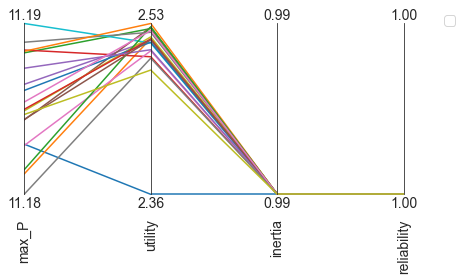

In [19]:
limits = parcoords.get_limits(policies_max_regret)
axes = parcoords.ParallelAxes(limits)
axes.plot(policies_max_regret) 
axes.legend()
plt.show()

In [28]:
policies_max_regret[policies_max_regret["utility"]==policies_max_regret.utility.min()]

,max_P,utility,inertia,reliability
policy,,,,
0,11.185558,2.362679,0.99,1.0


In [34]:
policies_max_regret.sort_values(by=["utility", "max_P"], ascending=True).head()

,max_P,utility,inertia,reliability
policy,,,,
0,11.185558,2.362679,0.99,1.0
18,11.186149,2.482834,0.99,1.0
17,11.184555,2.494268,0.99,1.0
3,11.187436,2.495678,0.99,1.0
6,11.185528,2.501442,0.99,1.0


Policy zero appears to yield the lowest regret, followed by Policy 18, 17 and 3. These results can also be clearly visualized. For example, Policy 0 is indicated by the blue line, while Policy 18 is indicated by the mustard yellow line.